# Final Project: NYPD Shooting Statistics Prediction Using Supervised Learning
## GitHub repo URL ##



## Data Source ##

The dataset is downloaded from:  

https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?accessType=DOWNLOAD


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import altair as alt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
# import seaborn as sns

# Introduction
This project focuses on addressing a supervised learning problem using data from the New York Police Department (NYPD) related to shooting incidents. The dataset contains records of shooting incidents across various boroughs in New York City, capturing details such as the date, time, location, and demographic information of the victims and perpetrators. The goal of this project is to predict future shooting incidents by leveraging temporal and demographic features extracted from the data. In this report, temporal features of the data will be used to develop a model based on XGBoost to predict shooting statistics in the future.

# Data Cleaning

In [4]:
# IMPORT: LOAD THE DATA FROM THE SOURCE

url = "https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?accessType=DOWNLOAD"
original_data = pd.read_csv(url)
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28562 entries, 0 to 28561
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             28562 non-null  int64  
 1   OCCUR_DATE               28562 non-null  object 
 2   OCCUR_TIME               28562 non-null  object 
 3   BORO                     28562 non-null  object 
 4   LOC_OF_OCCUR_DESC        2966 non-null   object 
 5   PRECINCT                 28562 non-null  int64  
 6   JURISDICTION_CODE        28560 non-null  float64
 7   LOC_CLASSFCTN_DESC       2966 non-null   object 
 8   LOCATION_DESC            13585 non-null  object 
 9   STATISTICAL_MURDER_FLAG  28562 non-null  bool   
 10  PERP_AGE_GROUP           19218 non-null  object 
 11  PERP_SEX                 19252 non-null  object 
 12  PERP_RACE                19252 non-null  object 
 13  VIC_AGE_GROUP            28562 non-null  object 
 14  VIC_SEX               

In [5]:
# DATA CLEANING: FEATURE SELECTION

cleaned_data = original_data.copy()

# Combining the date and time columns allows more advanced time analysis later
cleaned_data['OCCUR_DATETIME'] = pd.to_datetime(cleaned_data['OCCUR_DATE'] + ' ' + cleaned_data['OCCUR_TIME'],
                                                format='%m/%d/%Y %H:%M:%S')

# The following columns provide redundant info and will be dropped
drop_col = ['X_COORD_CD', 'Y_COORD_CD', 'Lon_Lat','OCCUR_DATE','OCCUR_TIME']
cleaned_data = cleaned_data.drop(columns = drop_col)

# The following columns do not provide valuable info and will be dropped
drop_col = ['INCIDENT_KEY', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOC_OF_OCCUR_DESC',
           'STATISTICAL_MURDER_FLAG']
cleaned_data = cleaned_data.drop(columns = drop_col)


In [6]:
# DATA CLEANING: HANDLING MISSING VALUES

# The following columns have missing values that can be replaced with 'UNKNOWN'
missing_col = ['LOCATION_DESC', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
for col in missing_col:
    cleaned_data[col].fillna('UNKNOWN', inplace=True)

# Replacing '(null)' and 'NONE' values with 'UNKNOWN'
cleaned_data.replace('(null)', 'UNKNOWN', inplace=True)
cleaned_data.replace('NONE', 'UNKNOWN', inplace=True)

# Fixing other value mismatches
bad_val = ['1020', '940', '224', '1028']
for val in bad_val:
    cleaned_data['PERP_AGE_GROUP'].replace(val, 'UNKNOWN', inplace=True)

cleaned_data['VIC_AGE_GROUP'].replace('1022', 'UNKNOWN', inplace=True)
cleaned_data['PERP_SEX'].replace('UNKNOWN', 'U', inplace=True)


In [7]:
# DATA CLEANING: REPLACING MISSING LATITUDE AND LONGITUDE VALUES

# Finding unique ('BORO', 'PRECINCT') of data with missing values
missing_lat_long = cleaned_data[cleaned_data['Latitude'].isnull() | 
                                cleaned_data['Longitude'].isnull()]
unique_combinations = missing_lat_long[['BORO', 'PRECINCT']].drop_duplicates()

# Calculate the mean Latitude and Longitude for the unique combinations
mean_latlong = {}
for _, row in unique_combinations.iterrows():
    boro = row['BORO']
    precinct = row['PRECINCT']
    mean_val = cleaned_data[(cleaned_data['BORO'] == boro) & (cleaned_data['PRECINCT'] == precinct)].agg(
        {'Latitude': 'mean', 'Longitude': 'mean'})
    mean_latlong[(boro, precinct)] = mean_val.round(6)

# replace the missing values with calculated ones

def fill_missing_latlong(row):
    if pd.isnull(row['Latitude']) or pd.isnull(row['Longitude']):
        key = (row['BORO'], row['PRECINCT'])
        if key in mean_latlong:
            if pd.isnull(row['Latitude']):
                row['Latitude'] = mean_latlong[key]['Latitude']
            if pd.isnull(row['Longitude']):
                row['Longitude'] = mean_latlong[key]['Longitude']
    return row
cleaned_data = cleaned_data.apply(fill_missing_latlong, axis=1)


In [8]:
# DATA CLEANING: FORMATTING

# The following columns all have 'category' data type
cat_col = ['BORO','PRECINCT','LOCATION_DESC','PERP_AGE_GROUP','PERP_SEX',
           'PERP_RACE','VIC_AGE_GROUP','VIC_SEX','VIC_RACE']
cleaned_data[cat_col] = cleaned_data[cat_col].astype('category')

# Verify that there are no missing values and appropriate formatting
cleaned_data.columns = cleaned_data.columns.str.lower()
cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28562 entries, 0 to 28561
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   boro            28562 non-null  category      
 1   precinct        28562 non-null  category      
 2   location_desc   28562 non-null  category      
 3   perp_age_group  28562 non-null  category      
 4   perp_sex        28562 non-null  category      
 5   perp_race       28562 non-null  category      
 6   vic_age_group   28562 non-null  category      
 7   vic_sex         28562 non-null  category      
 8   vic_race        28562 non-null  category      
 9   latitude        28562 non-null  float64       
 10  longitude       28562 non-null  float64       
 11  occur_datetime  28562 non-null  datetime64[ns]
dtypes: category(9), datetime64[ns](1), float64(2)
memory usage: 926.2 KB


# Data Analysis and Modeling
first we extract temporal features from the cleaned dataset and create a temporal dataframe. Then the data was aggregated hourly to preserve as much detail as possible.


In [10]:
# TEMPORAL
temporal_data = pd.DataFrame()
temporal_data['datetime'] = cleaned_data['occur_datetime']
temporal_data['count'] = temporal_data['datetime'].dt.hour
temporal_data = temporal_data.set_index('datetime')
temporal_data = temporal_data.resample('H').agg('count')
temporal_data['year'] = temporal_data.index.year
temporal_data['month'] = temporal_data.index.month
#temporal_data['day'] = temporal_data.index.day
temporal_data['hour'] = temporal_data.index.hour
temporal_data['dayofweek'] = temporal_data.index.dayofweek
temporal_data['dayofyear'] = temporal_data.index.dayofyear
#temporal_data['quarter'] = temporal_data.index.quarter
#temporal_data['weekofyear'] = temporal_data.index.isocalendar().week

temporal_data.sort_index()

,count,year,month,hour,dayofweek,dayofyear
datetime,,,,,,
2006-01-01 02:00:00,4,2006,1,2,6,1
2006-01-01 03:00:00,1,2006,1,3,6,1
2006-01-01 04:00:00,0,2006,1,4,6,1
2006-01-01 05:00:00,1,2006,1,5,6,1
2006-01-01 06:00:00,0,2006,1,6,6,1
...,...,...,...,...,...,...
2023-12-29 17:00:00,0,2023,12,17,4,363
2023-12-29 18:00:00,1,2023,12,18,4,363
2023-12-29 19:00:00,0,2023,12,19,4,363


In [11]:
def add_lags(df):
    target_map = df['count'].to_dict()
    df['lag1yr'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2yr'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3yr'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [13]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=0)
temporal_data = temporal_data.sort_index()
temporal_data = add_lags(temporal_data)
training_data = temporal_data[temporal_data.index < '2019/01/01']
testing_data = temporal_data[temporal_data.index >= '2019/01/01']

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(training_data):
    train = training_data.iloc[train_idx]
    validate = training_data.iloc[val_idx]


    
    x_train = train.drop(columns='count')
    y_train = train['count']

    x_val = validate.drop(columns='count')
    y_val = validate['count']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.01)
    reg.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_val, y_val)],
            verbose=100)

    y_pred = reg.predict(x_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred, y_val))
    scores.append(score)

[0]	validation_0-rmse:0.72126	validation_1-rmse:0.66200
[100]	validation_0-rmse:0.64359	validation_1-rmse:0.57867
[200]	validation_0-rmse:0.63077	validation_1-rmse:0.56412
[300]	validation_0-rmse:0.62728	validation_1-rmse:0.56134
[400]	validation_0-rmse:0.62572	validation_1-rmse:0.56133
[402]	validation_0-rmse:0.62570	validation_1-rmse:0.56132
[0]	validation_0-rmse:0.71493	validation_1-rmse:0.64166
[100]	validation_0-rmse:0.63688	validation_1-rmse:0.55404
[200]	validation_0-rmse:0.62379	validation_1-rmse:0.53938
[300]	validation_0-rmse:0.62028	validation_1-rmse:0.53625
[400]	validation_0-rmse:0.61863	validation_1-rmse:0.53576
[457]	validation_0-rmse:0.61811	validation_1-rmse:0.53579
[0]	validation_0-rmse:0.70795	validation_1-rmse:0.59092
[100]	validation_0-rmse:0.62922	validation_1-rmse:0.48132
[200]	validation_0-rmse:0.61612	validation_1-rmse:0.45936
[300]	validation_0-rmse:0.61266	validation_1-rmse:0.45410
[400]	validation_0-rmse:0.61121	validation_1-rmse:0.45281
[500]	validation_0-r

In [14]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.4905
Fold scores:[0.561110275797987, 0.5357535717884656, 0.4525164077493125, 0.43147441958708366, 0.4715668964847103]


<Axes: title={'center': 'Feature Importance'}>

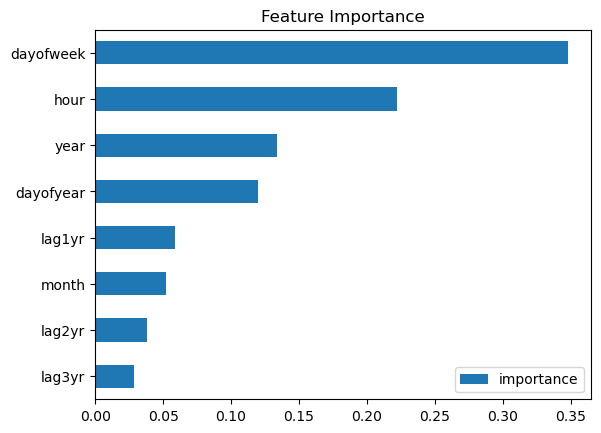

In [15]:
feature_importance = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_,
                                 columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh', title= 'Feature Importance')


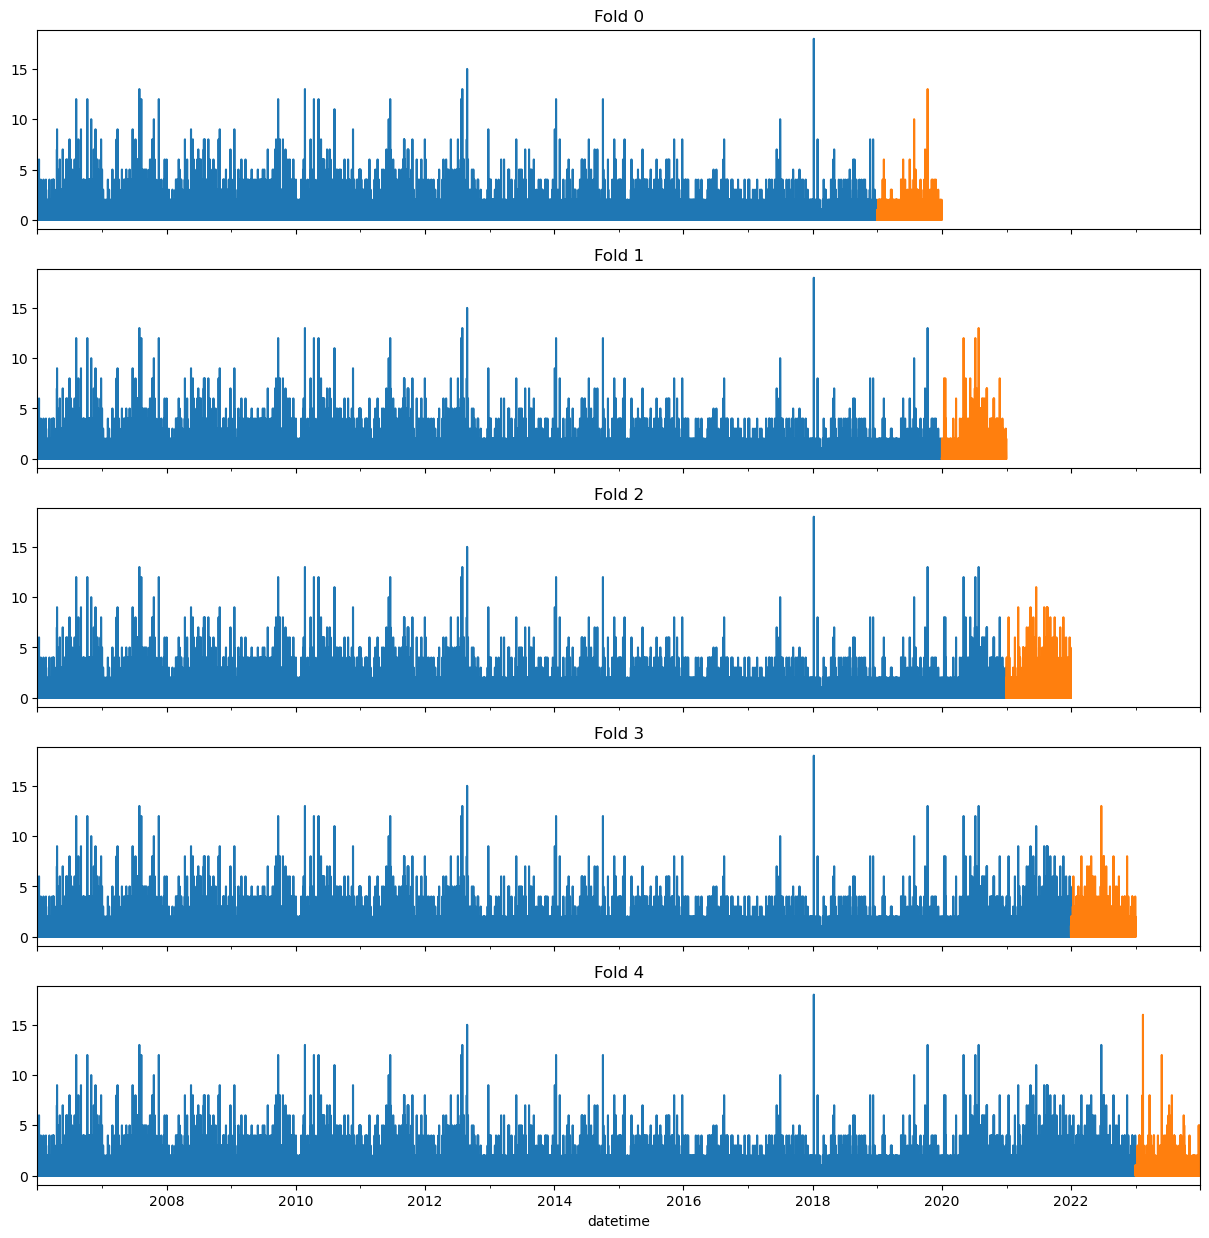

In [16]:
fig, axs = plt.subplots(5,1, figsize=(15, 15), sharex=True)

fold = 0

for train_indx, count_indx in tss.split(temporal_data):
    train = temporal_data.iloc[train_indx]
    test = temporal_data.iloc[count_indx]
    
    train['count'].plot(ax=axs[fold], label='Training set', title=f'Fold {fold}')
    test['count'].plot(ax=axs[fold], label='Test set')
    fold += 1
plt.show()

In [17]:
x_val = training_data.drop(columns='count')
y_val = training_data['count']

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.01)
reg.fit(x_val, y_val,
        eval_set=[(x_val, y_val)],
        verbose=100)

[0]	validation_0-rmse:0.68381
[100]	validation_0-rmse:0.59830
[200]	validation_0-rmse:0.58389
[300]	validation_0-rmse:0.58006
[400]	validation_0-rmse:0.57859
[500]	validation_0-rmse:0.57792
[600]	validation_0-rmse:0.57740
[700]	validation_0-rmse:0.57695
[800]	validation_0-rmse:0.57650
[900]	validation_0-rmse:0.57606
[999]	validation_0-rmse:0.57570


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
fold = 0
preds =[]
err = []
scores = []
for train_indx, val_indx in tss.split(temporal_data):
    train = temporal_data.iloc[train_indx]
    validate = temporal_data.iloc[val_indx]

    x_train = train.drop(columns='count')
    y_train = train['count']
    x_val = validate.drop(columns='count')
    y_val = validate['count']
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.01)
    reg.fit(x_train, y_train,
            eval_set=[(x_train, y_train)],
            verbose=False)
    
    y_pred = reg.predict(x_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred, y_val))
    percent_err = abs(sum(y_pred) - sum(y_val)) / sum(y_val) *100
    err.append(percent_err)
    scores.append(score)
    fold += 1

In [19]:
summary = pd.DataFrame()
summary['datetime'] = cleaned_data['occur_datetime']
summary['count'] = summary['datetime'].dt.hour
summary = summary.set_index('datetime')
summary = summary[summary.index >= '2019/01/01']
summary = summary.resample('Y').agg('count')
summary['predicted'] = [sum(i) for i in preds]
summary['percent_err'] = err
summary

,count,predicted,percent_err
datetime,,,
2019-12-31,967,987.173800,2.086225
2020-12-31,1948,981.930063,49.489194
2021-12-31,2011,1911.924702,4.832021
2022-12-31,1716,2038.826264,18.674404
2023-12-31,1250,1773.918896,41.235581


<Axes: xlabel='datetime'>

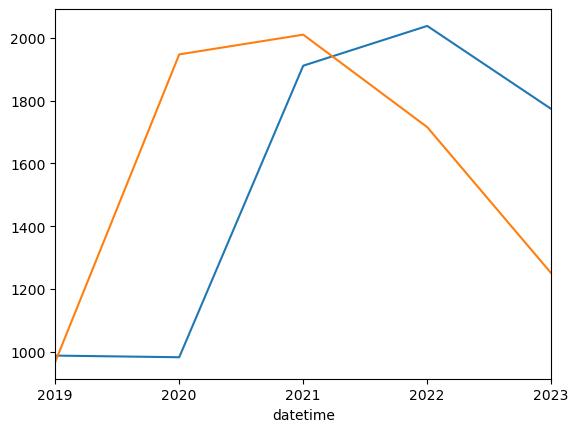

In [20]:
summary['predicted'].plot()
summary['count'].plot()